## Gaussian decomposable graphical model

Fitting multiple Gaussian decomposable graphical model to simulated G from auto-regressive process

In [1]:
SAVE_PLOTS = True
SAVE_IMG_LOC =  '/home/mo/src/decomposable_paper/img/CTA_uni_'
SAVE_LOC = '/home/mo/src/decomposable_paper/img/CTA_uni_'

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

import time
import trilearn
import trilearn.graph.junction_tree
import trilearn.graph.junction_tree as jtlib
import trilearn.graph.graph as glib
from trilearn.distributions import g_inv_wishart

from parallelDG.graph import trajectory
import parallelDG.graph.graph as glib
import parallelDG.graph.decomposable as dlib
import parallelDG.distributions.g_intra_class as gic
import parallelDG.auxiliary_functions as aux
from parallelDG.distributions import discrete_dec_log_linear as loglin
import parallelDG.mh_parallel as pdg
from networkx.drawing.nx_pydot import graphviz_layout
sns.set_style("whitegrid")
options = {
    "font_size": 8,
    "node_size": 100,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
}
def save_location(filename, loc = SAVE_IMG_LOC):
    if SAVE_PLOTS:
        plt.savefig(loc + filename + '.png', dpi = 600, bbox_inches='tight')
    else: 
        plt.show()

### Simulating AR(1-5) Gaussian graphical model

In [3]:
p = 25
n = 200
alpha = 0.5
beta = 0.5
D = np.matrix(np.identity(p))  # Scale parameter
delta = 1.0

Number of edges 60, number of nodes 25
loglikelihood 5593.877251


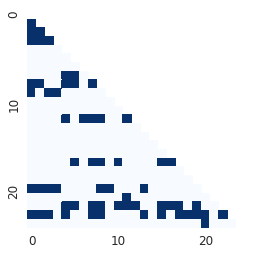

In [4]:
np.random.seed(3) # generates same data as in the paper
T = trilearn.graph.junction_tree.sample(p, alpha, beta)
G = jtlib.graph(T)
cov_mat = g_inv_wishart.sample(G, p, D)
cta_df = pd.DataFrame(np.random.multivariate_normal(np.zeros(p), cov_mat, n))
aux.plot_heatmap(nx.to_numpy_array(G), xticklabels=10, yticklabels=10)
#nx.draw(G, with_labels=True)
print('Number of edges {}, number of nodes {}'.format(G.size(), G.order()))
print('loglikelihood {:2f}'.format(pdg.ggm_loglikelihood(dataframe=cta_df,
                                                         graph=G,
                                                         graph_prior=['uniform'], 
                                                         delta=delta)))
save_location('ggm_true_graph_adj')

No. Edges 60


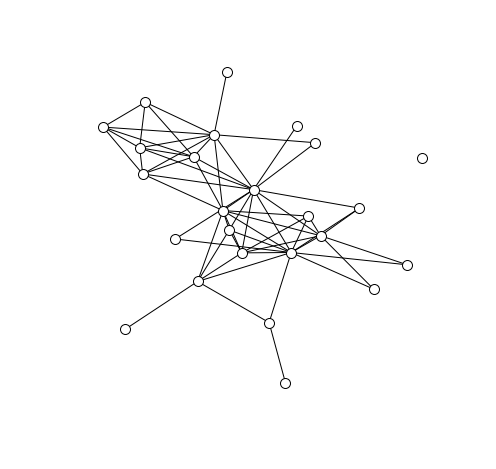

In [5]:
# Graph
plt.figure(figsize=(8,8))
pos = graphviz_layout(G, prog="fdp",)
nx.draw_networkx(G,pos=pos, with_labels=False, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
save_location('ggm_true_graph')
print('No. Edges {}'.format(G.number_of_edges()))

##  Multiple runs

In [6]:
randomize  = 100
graph_prior = ['uniform', 1.0]
delta = 5.0
burnin = 200000
def multiple_runs(seed, parallel = False):
    import json
    if not parallel:
        n_samples = 200000
        traj = pdg.sample_trajectory_ggm(dataframe=cta_df, 
                                 n_samples=n_samples,
                                 randomize=randomize, 
                                 graph_prior = graph_prior,
                                 delta = delta, 
                                 seed = seed,
                                 parallel = parallel)
        
    else:
        n_samples = 100000
        traj = pdg.sample_trajectory_ggm(dataframe=cta_df, 
                                     n_samples=n_samples,
                                     randomize=randomize, 
                                     graph_prior = graph_prior,
                                     delta = delta, 
                                     seed = seed,
                                     parallel=parallel)
    traj.graph_updates = None
    traj.set_graph_trajectories(index_type = 'mcmc_index')
    acc_mcmc_index = aux.acceptance_ratio(traj.trajectory)
    traj.size()
    size_mcmc_index = list(traj._size)
    traj.graph_updates = None
    traj._size=None
    traj.set_graph_trajectories(index_type = 'mcmc_subindex')
    traj.size()
    acc_mcmc_subindex = aux.acceptance_ratio(traj.trajectory)
    size_mcmc_subindex = list(traj._size)
            ## of the juncion tree
    up = [0] * traj.n_updates
    for x in traj.jt_updates: 
        up[x[1]-1] = 1
        
    
    burnin = 50000
    lag=20000
    df = pd.DataFrame({'mcmc_index': size_mcmc_index[-burnin:],
                   'mcmc_subindex': size_mcmc_subindex[-burnin:]})
    y_index = aux.autocorrelation_plot(df['mcmc_index'], label = 'MCMC index', 
                                 color = 'black', 
                                 lag =lag, 
                                 return_series=True)
    y_subindex = aux.autocorrelation_plot(df['mcmc_subindex'], 
                                              label = ' MCMC subindex',
                                              color = 'black',
                                              ls = ':', lag = lag,
                                              return_series=True)
        ## SAVE JSON
    data = {
            "autocorr_index" : y_index, 
            "autocorr_subindex": y_subindex, 
            "lag" : lag, 
            "burnin_last": burnin, 
            "size_mcmc_index" : size_mcmc_index, 
            "size_mcmc_subindex" :size_mcmc_subindex, 
            "acc_mcmc_index" : list(acc_mcmc_index[1]), 
            "acc_avg_index" : acc_mcmc_index[0],
            "acc_mcmc_subindex": list(acc_mcmc_subindex[1]), 
            "acc_avg_subindex" : acc_mcmc_subindex[0],
            "acc_mcmc_junction" : up, 
            "logl" : traj.logl,
        }
    if not parallel: 
        filename = SAVE_LOC + str(seed) + 'single_move.json'
    else:
        filename = SAVE_LOC + str(seed) + '.json'
    with open(filename, 'w') as outfile:
        json.dump(data, outfile)
    print('saved file:' + SAVE_LOC)

In [7]:
### Plotting multple autocorrelation plots
import json
def read_file(filename):
    """ Reads a trajectory from json-file.
    """
    with open(filename) as mcmc_file:
        mcmc_json = json.load(mcmc_file)
    return mcmc_json
    
def get_variable(variable, extra_name = ''):
    seeds = list(range(10))
    data = dict()
    for s in seeds: 
        filename = SAVE_LOC + str(s) + extra_name + '.json'
        d = read_file(filename)
        data[s] = d[variable]
    return data

# Start of run

In [8]:
%%time
seeds = [0,1,2,3,4,5,6,7,8,9]
# multi-move
for s in seeds: 
    multiple_runs(s)
# single-move
for s in seeds: 
    multiple_runs(s, True)
#multiple_runs(seeds)

Metropolis-Hastings - single-move: 100%|██████████| 199999/199999 [00:18<00:00, 10830.08it/s]


Total of 200000 updates, for an average of 1.00 per iteration or 10822.66updates/sec
Acceptance rate 0.6576
mcmc_index
Acceptance ratio 0.384192
mcmc_subindex
Acceptance ratio 0.384112


Metropolis-Hastings - single-move:   0%|          | 825/199999 [00:00<00:24, 8247.94it/s]

saved file:/home/mo/src/decomposable_paper/img/CTA_uni_


Metropolis-Hastings - single-move: 100%|██████████| 199999/199999 [00:21<00:00, 9112.95it/s] 


Total of 200000 updates, for an average of 1.00 per iteration or 9109.08updates/sec
Acceptance rate 0.6590
mcmc_index
Acceptance ratio 0.385597
mcmc_subindex
Acceptance ratio 0.385492


Metropolis-Hastings - single-move:   0%|          | 855/199999 [00:00<00:23, 8542.74it/s]

saved file:/home/mo/src/decomposable_paper/img/CTA_uni_


Metropolis-Hastings - single-move: 100%|██████████| 199999/199999 [00:22<00:00, 9009.71it/s] 


Total of 200000 updates, for an average of 1.00 per iteration or 9004.92updates/sec
Acceptance rate 0.6579
mcmc_index
Acceptance ratio 0.385657
mcmc_subindex
Acceptance ratio 0.385562


Metropolis-Hastings - single-move:   0%|          | 800/199999 [00:00<00:25, 7872.01it/s]

saved file:/home/mo/src/decomposable_paper/img/CTA_uni_


Metropolis-Hastings - single-move: 100%|██████████| 199999/199999 [00:21<00:00, 9264.39it/s] 


Total of 200000 updates, for an average of 1.00 per iteration or 9258.15updates/sec
Acceptance rate 0.6590
mcmc_index
Acceptance ratio 0.387647
mcmc_subindex
Acceptance ratio 0.387562


Metropolis-Hastings - single-move:   0%|          | 762/199999 [00:00<00:26, 7619.63it/s]

saved file:/home/mo/src/decomposable_paper/img/CTA_uni_


Metropolis-Hastings - single-move: 100%|██████████| 199999/199999 [00:22<00:00, 8712.95it/s]


Total of 200000 updates, for an average of 1.00 per iteration or 8706.82updates/sec
Acceptance rate 0.6633
mcmc_index
Acceptance ratio 0.387332
mcmc_subindex
Acceptance ratio 0.387237


Metropolis-Hastings - single-move:   0%|          | 867/199999 [00:00<00:22, 8666.95it/s]

saved file:/home/mo/src/decomposable_paper/img/CTA_uni_


Metropolis-Hastings - single-move: 100%|██████████| 199999/199999 [00:23<00:00, 8578.74it/s]


Total of 200000 updates, for an average of 1.00 per iteration or 8572.80updates/sec
Acceptance rate 0.6615
mcmc_index
Acceptance ratio 0.386837
mcmc_subindex
Acceptance ratio 0.386692


Metropolis-Hastings - single-move:   0%|          | 705/199999 [00:00<00:28, 7047.74it/s]

saved file:/home/mo/src/decomposable_paper/img/CTA_uni_


Metropolis-Hastings - single-move: 100%|██████████| 199999/199999 [00:23<00:00, 8577.04it/s]


Total of 200000 updates, for an average of 1.00 per iteration or 8570.95updates/sec
Acceptance rate 0.6570
mcmc_index
Acceptance ratio 0.384417
mcmc_subindex
Acceptance ratio 0.384362


Metropolis-Hastings - single-move:   0%|          | 700/199999 [00:00<00:29, 6811.00it/s]

saved file:/home/mo/src/decomposable_paper/img/CTA_uni_


Metropolis-Hastings - single-move: 100%|██████████| 199999/199999 [00:23<00:00, 8557.52it/s]


Total of 200000 updates, for an average of 1.00 per iteration or 8550.92updates/sec
Acceptance rate 0.6573
mcmc_index
Acceptance ratio 0.383472
mcmc_subindex
Acceptance ratio 0.383337


Metropolis-Hastings - single-move:   0%|          | 790/199999 [00:00<00:25, 7893.53it/s]

saved file:/home/mo/src/decomposable_paper/img/CTA_uni_


Metropolis-Hastings - single-move: 100%|██████████| 199999/199999 [00:22<00:00, 8813.41it/s]


Total of 200000 updates, for an average of 1.00 per iteration or 8807.01updates/sec
Acceptance rate 0.6599
mcmc_index
Acceptance ratio 0.386912
mcmc_subindex
Acceptance ratio 0.386847


Metropolis-Hastings - single-move:   0%|          | 742/199999 [00:00<00:26, 7416.22it/s]

saved file:/home/mo/src/decomposable_paper/img/CTA_uni_


Metropolis-Hastings - single-move: 100%|██████████| 199999/199999 [00:23<00:00, 8506.64it/s]


Total of 200000 updates, for an average of 1.00 per iteration or 8500.72updates/sec
Acceptance rate 0.6586
mcmc_index
Acceptance ratio 0.383432
mcmc_subindex
Acceptance ratio 0.383277


Metropolis-Hastings - parallel moves:   0%|          | 368/99999 [00:00<00:27, 3668.67it/s]

saved file:/home/mo/src/decomposable_paper/img/CTA_uni_


Metropolis-Hastings - parallel moves: 100%|██████████| 99999/99999 [00:45<00:00, 2195.36it/s]


Total of 382999 updates, for an average of 3.83 per iteration or 8406.21updates/sec
Acceptance rate 0.8286
mcmc_index
Acceptance ratio 0.568216
mcmc_subindex
Acceptance ratio 0.232390


Metropolis-Hastings - parallel moves:   0%|          | 350/99999 [00:00<00:28, 3496.50it/s]

saved file:/home/mo/src/decomposable_paper/img/CTA_uni_


Metropolis-Hastings - parallel moves: 100%|██████████| 99999/99999 [00:46<00:00, 2150.61it/s]


Total of 382663 updates, for an average of 3.83 per iteration or 8227.42updates/sec
Acceptance rate 0.8302
mcmc_index
Acceptance ratio 0.566036
mcmc_subindex
Acceptance ratio 0.229396


Metropolis-Hastings - parallel moves:   0%|          | 352/99999 [00:00<00:28, 3518.87it/s]

saved file:/home/mo/src/decomposable_paper/img/CTA_uni_


Metropolis-Hastings - parallel moves: 100%|██████████| 99999/99999 [01:23<00:00, 1198.64it/s]


Total of 383666 updates, for an average of 3.84 per iteration or 4597.34updates/sec
Acceptance rate 0.8311
mcmc_index
Acceptance ratio 0.571736
mcmc_subindex
Acceptance ratio 0.233764


Metropolis-Hastings - parallel moves:   0%|          | 144/99999 [00:00<01:10, 1422.32it/s]

saved file:/home/mo/src/decomposable_paper/img/CTA_uni_


Metropolis-Hastings - parallel moves: 100%|██████████| 99999/99999 [03:39<00:00, 456.09it/s]


Total of 381330 updates, for an average of 3.81 per iteration or 1739.01updates/sec
Acceptance rate 0.8283
mcmc_index
Acceptance ratio 0.561666
mcmc_subindex
Acceptance ratio 0.228391


Metropolis-Hastings - parallel moves:   0%|          | 0/99999 [00:00<?, ?it/s]

saved file:/home/mo/src/decomposable_paper/img/CTA_uni_


Metropolis-Hastings - parallel moves: 100%|██████████| 99999/99999 [03:29<00:00, 477.37it/s]


Total of 380058 updates, for an average of 3.80 per iteration or 1813.91updates/sec
Acceptance rate 0.8285
mcmc_index
Acceptance ratio 0.562586
mcmc_subindex
Acceptance ratio 0.228168


Metropolis-Hastings - parallel moves:   0%|          | 100/99999 [00:00<01:45, 950.41it/s]

saved file:/home/mo/src/decomposable_paper/img/CTA_uni_


Metropolis-Hastings - parallel moves: 100%|██████████| 99999/99999 [03:03<00:00, 546.38it/s]


Total of 386070 updates, for an average of 3.86 per iteration or 2109.07updates/sec
Acceptance rate 0.8308
mcmc_index
Acceptance ratio 0.569546
mcmc_subindex
Acceptance ratio 0.231192


Metropolis-Hastings - parallel moves:   0%|          | 370/99999 [00:00<00:27, 3681.70it/s]

saved file:/home/mo/src/decomposable_paper/img/CTA_uni_


Metropolis-Hastings - parallel moves: 100%|██████████| 99999/99999 [00:47<00:00, 2122.19it/s]


Total of 382900 updates, for an average of 3.83 per iteration or 8123.82updates/sec
Acceptance rate 0.8304
mcmc_index
Acceptance ratio 0.564736
mcmc_subindex
Acceptance ratio 0.230272


Metropolis-Hastings - parallel moves:   0%|          | 442/99999 [00:00<00:22, 4414.34it/s]

saved file:/home/mo/src/decomposable_paper/img/CTA_uni_


Metropolis-Hastings - parallel moves: 100%|██████████| 99999/99999 [00:45<00:00, 2180.49it/s]


Total of 381708 updates, for an average of 3.82 per iteration or 8320.73updates/sec
Acceptance rate 0.8307
mcmc_index
Acceptance ratio 0.564776
mcmc_subindex
Acceptance ratio 0.228568


Metropolis-Hastings - parallel moves:   0%|          | 409/99999 [00:00<00:24, 4086.27it/s]

saved file:/home/mo/src/decomposable_paper/img/CTA_uni_


Metropolis-Hastings - parallel moves: 100%|██████████| 99999/99999 [00:51<00:00, 1943.70it/s]


Total of 385720 updates, for an average of 3.86 per iteration or 7495.57updates/sec
Acceptance rate 0.8335
mcmc_index
Acceptance ratio 0.569056
mcmc_subindex
Acceptance ratio 0.229719
saved file:/home/mo/src/decomposable_paper/img/CTA_uni_


Metropolis-Hastings - parallel moves: 100%|██████████| 99999/99999 [00:48<00:00, 2048.93it/s]


Total of 383176 updates, for an average of 3.83 per iteration or 7848.87updates/sec
Acceptance rate 0.8315
mcmc_index
Acceptance ratio 0.569956
mcmc_subindex
Acceptance ratio 0.232930
saved file:/home/mo/src/decomposable_paper/img/CTA_uni_
CPU times: user 2h 10min 48s, sys: 12min 46s, total: 2h 23min 35s
Wall time: 2h 13min 52s


In [9]:
data = get_variable('autocorr_index')
x = np.arange(len(data[0])) + 1
datasub = get_variable('autocorr_subindex')

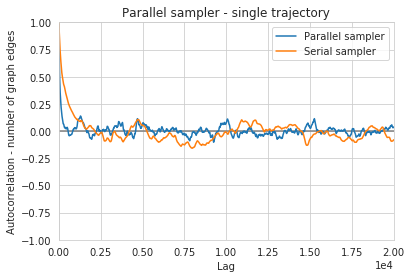

In [10]:
ax = plt.gca(xlim=(1, np.max(x)), ylim=(-1.0, 1.0))
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation - number of graph edges")
i = 1
ax.plot(x, data[i], label = 'Parallel sampler')
ax.plot(x, datasub[i], label = 'Serial sampler')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Parallel sampler - single trajectory')
plt.legend()
save_location('ggm_traj_autocorrelation_index_sub')

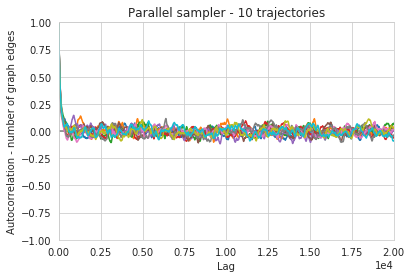

In [11]:
data = get_variable('autocorr_index')
x = np.arange(len(data[0])) + 1
ax = plt.gca(xlim=(1, np.max(x)), ylim=(-1.0, 1.0))
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation - number of graph edges")
for key, y in data.items(): 
    ax.plot(x, y)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Parallel sampler - 10 trajectories')
save_location('ggm_10_traj_autocorrelation')

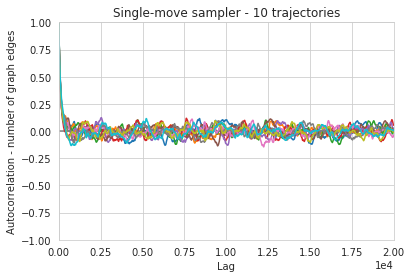

In [12]:
data = get_variable('autocorr_index', 'single_move')
x = np.arange(len(data[0])) + 1
ax = plt.gca(xlim=(1, np.max(x)), ylim=(-1.0, 1.0))
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation - number of graph edges")
#ax.set_ylabel("Autocorrelation")
for key, y in data.items(): 
    ax.plot(x, y)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Single-move sampler - 10 trajectories')
save_location('ggm_10_traj_autocorrelation_single_move')    

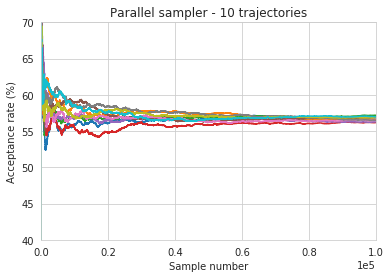

In [22]:
data = get_variable('acc_mcmc_index')
x = np.arange(len(data[0])) + 1
ax = plt.gca(xlim=(1, np.max(x)), ylim=(40, 70))
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Sample number")
ax.set_ylabel("Acceptance rate (%)")
for key, y in data.items(): 
    ax.plot(x, np.array(y) * 100.0)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Parallel sampler - 10 trajectories')
save_location('ggm_10_traj_acceptance_ratio')

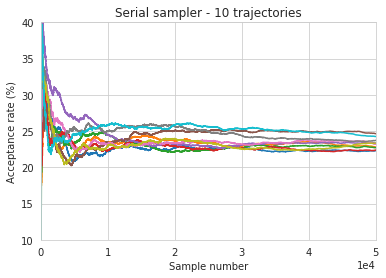

In [14]:
data = get_variable('acc_mcmc_subindex')
max_x = 50000
x = np.arange(max_x) + 1
ax = plt.gca(xlim=(1, max_x), ylim=(10, 40))
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Sample number")
ax.set_ylabel("Acceptance rate (%)")
for key, y in data.items(): 
    ax.plot(x, np.array(y[:max_x])* 100.0)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Serial sampler - 10 trajectories')
save_location('ggm_10_traj_acceptance_ratio_subindex')

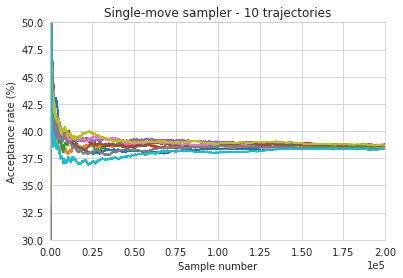

In [23]:
data = get_variable('acc_mcmc_index', 'single_move')
x = np.arange(len(data[0])) + 1
ax = plt.gca(xlim=(1, np.max(x)), ylim=(30, 50))
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Sample number")
ax.set_ylabel("Acceptance rate (%)")
for key, y in data.items(): 
    ax.plot(x, np.array(y) * 100.0)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Single-move sampler - 10 trajectories')
save_location('ggm_10_traj_acceptance_ratio_single_move')

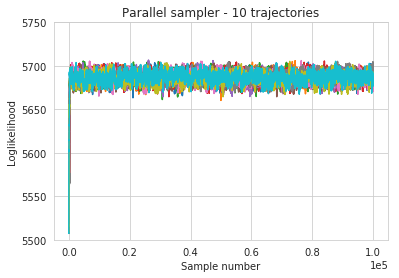

In [16]:
data = get_variable('logl')
burnin = 0
for key, y in data.items():
    yy = y[-burnin:]
    x = list(range(len(yy)))
    plt.plot(x, yy)

plt.xlabel('Sample number')
plt.ylabel('Loglikelihood')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylim((5500,5750))
plt.title('Parallel sampler - 10 trajectories')
save_location('ggm_10_traj_loglikelihood_traceplot')

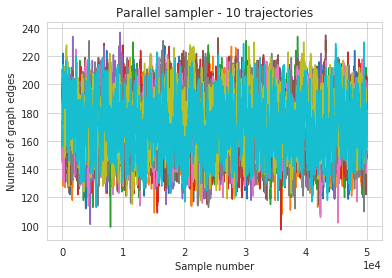

In [17]:
data = get_variable('size_mcmc_index')
burnin = 50000
x = list(range(burnin))
for key, y in data.items():
    plt.plot(x, y[-burnin:])

plt.xlabel('Sample number')
plt.ylabel('Number of graph edges')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Parallel sampler - 10 trajectories')
save_location('ggm_10_traj_size_traceplot')

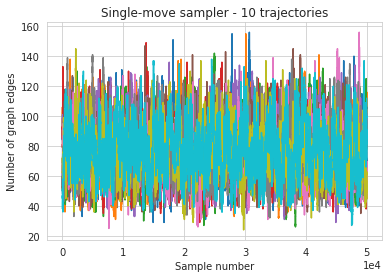

In [18]:
data = get_variable('size_mcmc_index', 'single_move')
burnin = 50000
x = list(range(burnin))
for key, y in data.items():
    plt.plot(x, y[-burnin:])

plt.xlabel('Sample number')
plt.ylabel('Number of graph edges')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Single-move sampler - 10 trajectories')
save_location('ggm_10_traj_size_traceplot_single_move')

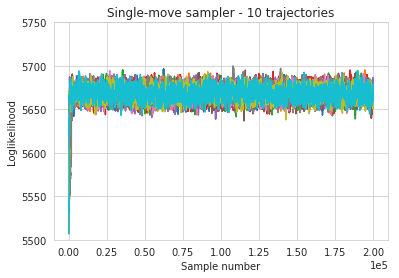

In [19]:
data = get_variable('logl', 'single_move')
burnin = 0
for key, y in data.items():
    yy = y[-burnin:]
    x = list(range(len(yy)))
    plt.plot(x, yy)

plt.xlabel('Sample number')
plt.ylabel('Loglikelihood')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylim((5500,5750))
plt.title('Single-move sampler - 10 trajectories')
save_location('ggm_10_traj_loglikelihood_traceplot_single_move')

In [20]:
data = get_variable('acc_mcmc_index')
datasub = get_variable('acc_mcmc_subindex')
x = np.arange(len(datasub[0])) + 1
datasingle = get_variable('acc_mcmc_index', 'single_move')

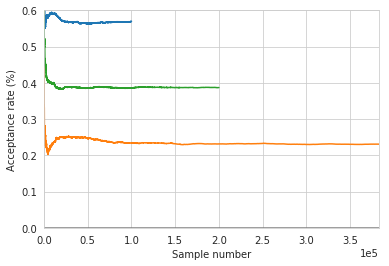

In [21]:
i = 5#1,8,5
max_x = np.max(x)
ax = plt.gca(xlim=(1, max_x), ylim=(0, 0.6))
y = data[i]
z = datasub[i]
f = datasingle[i]
ax.plot(list(range(len(y))), y, label = 'MCMC index')
ax.plot(list(range(len(z))), z, label = 'MCMC subindex')
ax.plot(list(range(len(f))), f, label = 'single-move')
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Sample number")
ax.set_ylabel("Acceptance rate (%)")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
#plt.title('Parallel sampler - MCMC subindex - 10 trajectories')
#save_location('ggm_10_traj_acceptance_ratio_subindex')